In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
x_train = np.load('/content/gdrive/My Drive/DL_Project/x_train.npy').astype(np.float32)
y_train = np.load('/content/gdrive/My Drive/DL_Project/y_train.npy').astype(np.float32)
x_val = np.load('/content/gdrive/My Drive/DL_Project/x_val.npy').astype(np.float32)
y_val = np.load('/content/gdrive/My Drive/DL_Project/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


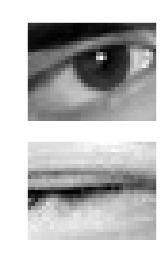

In [5]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [7]:
# Model Build
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [9]:
# Train
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('/content/gdrive/My Drive/DL_Project/CNNv1.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
81/81 [==============================] - 32s 23ms/step - loss: 0.5674 - acc: 0.6679 - val_loss: 0.3098 - val_acc: 0.8715

Epoch 00001: val_acc improved from -inf to 0.87153, saving model to /content/gdrive/My Drive/DL_Project/CNNv1.h5
Epoch 2/50
81/81 [==============================] - 2s 19ms/step - loss: 0.2947 - acc: 0.8764 - val_loss: 0.0948 - val_acc: 0.9688

Epoch 00002: val_acc improved from 0.87153 to 0.96875, saving model to /content/gdrive/My Drive/DL_Project/CNNv1.h5
Epoch 3/50
81/81 [==============================] - 2s 19ms/step - loss: 0.1779 - acc: 0.9291 - val_loss: 0.0786 - val_acc: 0.9688

Epoch 00003: val_acc did not improve from 0.96875
Epoch 4/50
81/81 [==============================] - 2s 20ms/step - loss: 0.1131 - acc: 0.9623 - val_loss: 0.0891 - val_acc: 0.9653

Epoch 00004: val_acc did not improve from 0.96875
Epoch 5/50
81/81 [==============================] - 2s 20ms/step - loss: 0.1126 - acc: 0.9582 - val_loss: 0.0605 - val_acc: 0.9792

Epoch 0000

test acc: 1.0


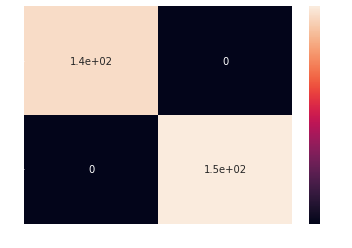

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('/content/gdrive/My Drive/DL_Project/CNNv1.h5')

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)